### idea of eigenface algorithim

In [1]:
# The Eigenfaces algorithm is based on the idea that any face image can be represented as a linear combination of a set of basic faces called Eigenfaces.
# meaning that, instead of storing every pixel, we only store the most important principal components that distinguish different faces.      

### steps

In [3]:
#1- Collect Training Images
#2- Convert Each Image to a Vector (flatten)
#3- Compute the Mean Face (the general structure of any face)
#4- Subtract the Mean Face (so that the algorighim can focus on differences between faces rather than overall charactaristics)
#5- decompose to find principle components of differences
    #-> SVD (will do that)
    #-> eigen decomposition : covariance then eigen decomposition (very slow because of eigen of covariance matrix)
#6- choose k component based on desired confidence
#7 – Represent Each Image in the Eigenfaces Space

### implementation

In [4]:
class FaceRecognizer:
    def __init__(self, dataset_path, confidence = .95):
        self.dataset_path = dataset_path
        self.confidence = confidence
        self.k=None
        self.face_data = []
        self.labels = []
        self.mean_face = None
        self.eigenfaces = None
        self.weights = None
        self.image_shape = None

    # ========================
    # 1. Load Dataset
    # ========================
    def load_data(self):
        for label_folder in os.listdir(self.dataset_path):
            folder_path = os.path.join(self.dataset_path, label_folder)
            if not os.path.isdir(folder_path):
                continue
            for filename in os.listdir(folder_path):
                if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                    img_path = os.path.join(folder_path, filename)
                    img = plt.imread(img_path)
                    if img.ndim == 3:  # convert RGB → Gray
                        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                    img = cv2.resize(img, (100, 100))  # normalize size
                    self.face_data.append(img.flatten())
                    self.labels.append(label_folder)
        
        self.face_data = np.array(self.face_data)
        self.image_shape = (100, 100)
        print(f"[INFO] Loaded {len(self.face_data)} images with shape {self.image_shape}")

    # ========================
    # 2. Train using SVD
    # ========================
    def train(self):
        self.load_data()

        # Step 1: Compute Mean Face
        self.mean_face = np.mean(self.face_data, axis=0)
        faces_centered = self.face_data - self.mean_face

        # Step 2: Apply SVD
        print("[INFO] Performing SVD...")
        U, S, Vt = np.linalg.svd(faces_centered, full_matrices=False)
        explained_variance_ratio = (S ** 2) / np.sum(S ** 2)
        cumulative_variance = np.cumsum(explained_variance_ratio)
        self.k = np.argmax(cumulative_variance >= self.confidence) + 1
        
        # Step 3: Keep Top K Components
        self.eigenfaces = Vt[:self.k, :]
        # Step 4: Project Training Images into Eigen Space
        self.weights = faces_centered @ self.eigenfaces.T
        print("[INFO] Training complete!")

        
    # ========================
    # 2. recognize based on min distance
    # ========================
    
    def recognize(self , test_img):
        img = cv2.imread(test_img, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.image_shape)
        img_flat = img.flatten()
        img_centered = img_flat - self.mean_face
        test_weight = img_centered @ self.eigenfaces.T
        distances = np.linalg.norm(self.weights - test_weight, axis=1)
        min_index = np.argmin(distances)
        pred_label = self.labels[min_index]
        distance_value = distances[min_index]
        print(f"[RESULT] Predicted Label: {pred_label}")
        print(f"         Distance: {distance_value:.2f}")



In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
data_path=r"faces_dataset\train"
test_path=r"faces_dataset\test"

In [6]:
recognizer = FaceRecognizer(data_path)  # confidence can be adjusted
recognizer.train()

[INFO] Loaded 31 images with shape (100, 100)
[INFO] Performing SVD...
[INFO] Training complete!


[INFO] Testing: haland.jpeg


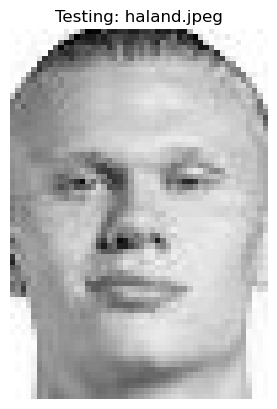

[RESULT] Predicted Label: Haland
         Distance: 2415.57
[INFO] Testing: kante.png


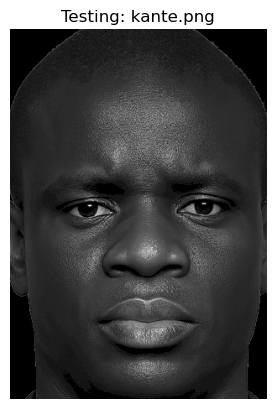

[RESULT] Predicted Label: Haland
         Distance: 4773.79
[INFO] Testing: lio.jpg


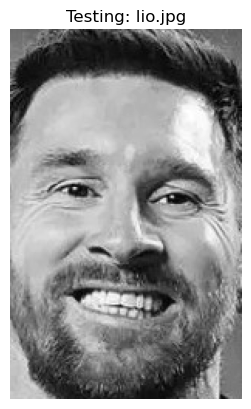

[RESULT] Predicted Label: messi
         Distance: 2028.76
[INFO] Testing: messi.png


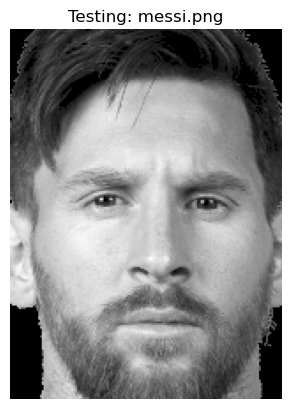

[RESULT] Predicted Label: messi
         Distance: 3911.46
[INFO] Testing: suarez.jpg


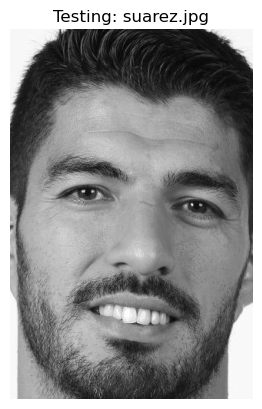

[RESULT] Predicted Label: Suarez
         Distance: 1505.28


In [7]:
for filename in os.listdir(test_path):
    img_path = os.path.join(test_path, filename)
    if os.path.isfile(img_path) and filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        print(f"[INFO] Testing: {filename}")
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.imshow(img, cmap='gray')
        plt.title(f"Testing: {filename}")
        plt.axis('off')
        plt.show()
        recognizer.recognize(img_path)


In [8]:
# ouch , missed 1